In [1]:
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from urllib.request import urlopen 
%matplotlib inline

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)

In [2]:
# Loading data and cleaning dataset
UCI_data_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases\
/breast-cancer-wisconsin/wdbc.data'

Next, I created a list with the appropriate names and set them as the data frame's column names,

In [3]:
names = ['id_number', 'diagnosis', 'radius_mean', 
         'texture_mean', 'perimeter_mean', 'area_mean', 
         'smoothness_mean', 'compactness_mean', 
         'concavity_mean','concave_points_mean', 
         'symmetry_mean', 'fractal_dimension_mean',
         'radius_se', 'texture_se', 'perimeter_se', 
         'area_se', 'smoothness_se', 'compactness_se', 
         'concavity_se', 'concave_points_se', 
         'symmetry_se', 'fractal_dimension_se', 
         'radius_worst', 'texture_worst', 
         'perimeter_worst', 'area_worst', 
         'smoothness_worst', 'compactness_worst', 
         'concavity_worst', 'concave_points_worst', 
         'symmetry_worst', 'fractal_dimension_worst'] 

dx = ['Benign', 'Malignant']

In [4]:
wbcd_df = pd.read_csv(urlopen(UCI_data_URL), names=names)

### Cleaning
We do some minor cleanage like setting the id_number to be the data frame index, along with converting the diagnosis to the standard binary 1, 0 representation using the map() function.

In [5]:
# Setting 'id_number' as our index
wbcd_df.set_index(['id_number'], inplace = True) 
# Converted to binary to help later on with models and plots
wbcd_df['diagnosis'] = wbcd_df['diagnosis'].map({'M':1, 'B':0})

In [6]:
wbcd_df.shape

(569, 31)

### Missing Values
Given context of the data set, we know that there is no missing data, but we want to make sure that there are no missing values.

In [7]:
wbcd_df.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

### Exploration

Let us explore the data to get some insight


In [8]:
wbcd_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
id_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [9]:
# dimension of the data
print("Here's the dimensions of our data:\n", wbcd_df.shape)

Here's the dimensions of our data:
 (569, 31)


In [10]:
## Type of variables

print("Here's the data types of various variables:\n", wbcd_df.dtypes)

Here's the data types of various variables:
 diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave_points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave_points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_

Next we will see some useful standard descriptive statistics for each feature 
including mean, standard deviation, minimum value, maximum value, and range intervals.

In [11]:
# Some summary of the data
wbcd_df.describe()
#wbcd_df.describe().T

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


We can see through the maximum row that our data varies in distribution, this will be important when considering classification models.

Standardization is an important requirement for many classification models that should be considered when implementing pre-processing. Some models can perform poorly if pre-processing isn't considered, so the describe() function can be a good indicator for standardization. Fortunately Random Forest does not require any pre-processing.

### Class Imbalance
The distribution for diagnosis is important because it brings up the discussion of Class Imbalance within Machine learning and data mining applications.

In [12]:
wbcd_df['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [13]:
# To see the perecentage of each class

wbcd_df['diagnosis'].value_counts()/len(wbcd_df)

0    0.627417
1    0.372583
Name: diagnosis, dtype: float64

Fortunately, this data set does not suffer from class imbalance.

### Creating Training and Test Sets

We split the data set into our training and test sets which will be randomly selected having a 80-20% splt. We will use the training set to train our model, and use our test set as the unseen data that will be a useful final metric to let us know how well our model does.


In [14]:
wbcd_df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [15]:
#X = wbcd_df.iloc[:, wbcd_df.columns != 'diagnosis']
#y = wbcd_df.iloc[:, wbcd_df.columns == 'diagnosis']
X = wbcd_df.iloc[:, 1:]
y = wbcd_df.iloc[:, 0]

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 123)


### Fitting Random Forest

In [16]:
rf = RandomForestClassifier(random_state=456)

rf.fit(X_train, y_train)   # with default settings

/Users/home/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=456, verbose=0, warm_start=False)

In [20]:
# Save the model
import pickle
pickle.dump(rf,open("rf_model",'wb'))

In [ ]:
# Load the model
rf_loaded = pickle.load(open(rf_model, 'rb'))
y_pred1 = rf.loaded.predict(X_test)

In [15]:
y_pred = rf.predict(X_test)

In [16]:
print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))  

print(accuracy_score(y_test, y_pred)) 

print(rf.score(X_test, y_test))

[[73  0]
 [ 1 40]]
0.9912280701754386
0.9912280701754386


In [17]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9878048780487805

### Variable Importance
Once we have the trained model, we can assess importance of variables. 

In [19]:
import pandas as pd
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
concave_points_worst,0.171755
area_mean,0.141737
area_worst,0.110454
perimeter_worst,0.098129
radius_se,0.090715
radius_worst,0.080522
radius_mean,0.067773
concavity_mean,0.049563
concave_points_mean,0.022466
compactness_worst,0.021576


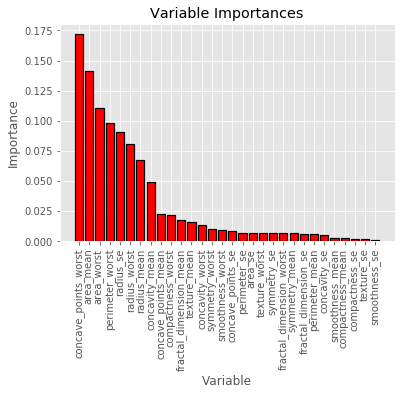

In [20]:
x_values = list(range(len(feature_importances['importance'])))
plt.bar(x_values, feature_importances['importance'], orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_importances.index, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

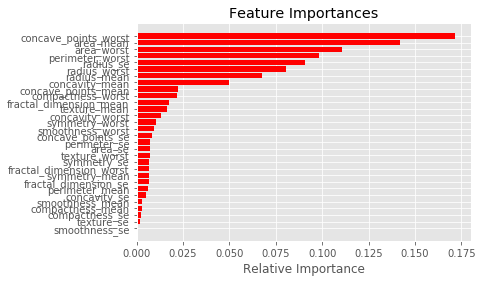

In [21]:
### Aoother way 

features = X.columns.values
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

### Tuning the parameters

#### N_estimators

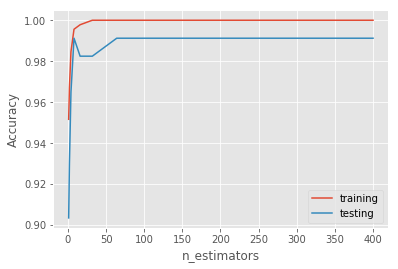

In [18]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 400]
tr_accuracy = []
tst_accuracy = []

tr_auc = []
tst_auc = []
for est in n_estimators:
    rf = RandomForestClassifier(n_estimators= est)
    rf.fit(X_train,y_train)
    tr_pred = rf.predict(X_train)
    tr_accuracy.append(accuracy_score(y_train, tr_pred))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, tr_pred)
    roc_auc_tr = auc(false_positive_rate, true_positive_rate)
    tr_auc.append(roc_auc_tr)
    
    
    tst_pred = rf.predict(X_test)
    tst_accuracy.append(accuracy_score(y_test, tst_pred))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, tst_pred)
    roc_auc_tst = auc(false_positive_rate, true_positive_rate)
    tst_auc.append(roc_auc_tst)

line_1, = plt.plot(n_estimators, tr_accuracy, label='training')
line_2, = plt.plot(n_estimators, tst_accuracy, label='testing')
plt.legend(handles=[line_1, line_2])
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')


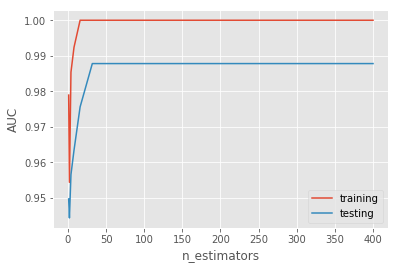

In [23]:
line_1, = plt.plot(n_estimators, tr_auc, label='training')
line_2, = plt.plot(n_estimators, tst_auc, label='testing')
plt.legend(handles=[line_1, line_2])
plt.ylabel('AUC')
plt.xlabel('n_estimators')


#### max_depth

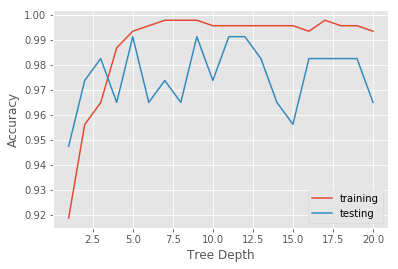

In [24]:
max_depths = np.linspace(1, 20,20, endpoint=True)

tr_accuracy = []
tst_accuracy = []

tr_auc = []
tst_auc = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth = max_depth)
    rf.fit(X_train,y_train)
    tr_pred = rf.predict(X_train)
    tr_accuracy.append(accuracy_score(y_train, tr_pred))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, tr_pred)
    roc_auc_tr = auc(false_positive_rate, true_positive_rate)
    tr_auc.append(roc_auc_tr)
    
    
    tst_pred = rf.predict(X_test)
    tst_accuracy.append(accuracy_score(y_test, tst_pred))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, tst_pred)
    roc_auc_tst = auc(false_positive_rate, true_positive_rate)
    tst_auc.append(roc_auc_tst)

line_1, = plt.plot(max_depths, tr_accuracy, label='training')
line_2, = plt.plot(max_depths, tst_accuracy, label='testing')
plt.legend(handles=[line_1, line_2])
plt.ylabel('Accuracy')
plt.xlabel('Tree Depth')

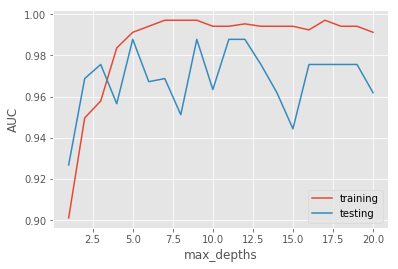

In [25]:
line_1, = plt.plot(max_depths, tr_auc, label='training')
line_2, = plt.plot(max_depths, tst_auc, label='testing')
plt.legend(handles=[line_1, line_2])
plt.ylabel('AUC')
plt.xlabel('max_depths')


#### max_features

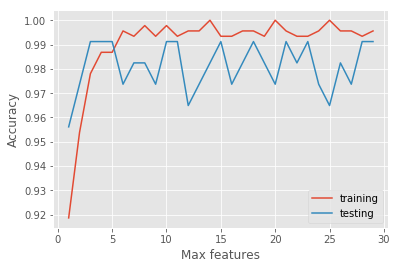

In [26]:
max_features = list(range(1,X_train.shape[1]))

tr_accuracy = []
tst_accuracy = []

tr_auc = []
tst_auc = []
for i in max_features:
    rf = RandomForestClassifier(max_depth = i)
    rf.fit(X_train,y_train)
    tr_pred = rf.predict(X_train)
    tr_accuracy.append(accuracy_score(y_train, tr_pred))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, tr_pred)
    roc_auc_tr = auc(false_positive_rate, true_positive_rate)
    tr_auc.append(roc_auc_tr)
    
    
    tst_pred = rf.predict(X_test)
    tst_accuracy.append(accuracy_score(y_test, tst_pred))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, tst_pred)
    roc_auc_tst = auc(false_positive_rate, true_positive_rate)
    tst_auc.append(roc_auc_tst)

line_1, = plt.plot(max_features, tr_accuracy, label='training')
line_2, = plt.plot(max_features, tst_accuracy, label='testing')
plt.legend(handles=[line_1, line_2])
plt.ylabel('Accuracy')
plt.xlabel('Max features')

We can utilize **GridSearchCV** functionality to optimize the parameters


In [27]:
np.random.seed(123)
start = time.time()
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
max_depths = (2,3,4)
boot_strap = (True, False)
min_samples_splits = [2,3,5]
min_samples_leafs = [1,5,8]
max_features = ('auto', 'sqrt', 'log2', None)
criteria = ('gini', 'entropy')
parameters = {'max_depth': max_depths,
              'bootstrap': boot_strap,
              'max_features': max_features,
              'criterion': criteria,
              'min_samples_split': min_samples_splits,
              'min_samples_leaf': min_samples_leafs
             }

rf = RandomForestClassifier(random_state=456)

#rf.fit(X_train, y_train)   # with default settings
rf_model = GridSearchCV(rf, parameters,cv = 10,n_jobs = 3)

rf_model.fit(X_train, y_train)
print('Best Parameters using grid search: \n', 
      rf_model.best_params_)

end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

# Set the rf to the best combination of parameters
rf = rf_model.best_estimator_

# Fit the best algorithm to the data. 
rf.fit(X_train, y_train)

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Time taken in grid search:  75.66


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=456, verbose=0, warm_start=False)

In [28]:
y_pred = rf.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test,y_pred))

Accuracy Score: 0.9824561403508771


#### Validate with KFold
Is this model actually any good? It helps to verify the effectiveness of the algorithm using KFold. This will split our data into 10 buckets, then run the algorithm using a different bucket as the test set for each iteration.

In [33]:
# https://www.kaggle.com/cesartrevisan/scikit-learn-and-gridsearchcv

from sklearn.cross_validation import KFold

def run_kfold(rf):
    kf = KFold(len(y), n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        rf.fit(X_train, y_train)
        predictions = rf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome))
    std_outcome = np.std(outcomes)
    print("Std Accuracy: {0}".format(std_outcome))

    
run_kfold(rf)

Fold 1 accuracy: 0.9473684210526315
Fold 2 accuracy: 0.8947368421052632
Fold 3 accuracy: 0.9122807017543859
Fold 4 accuracy: 0.9473684210526315
Fold 5 accuracy: 0.9298245614035088
Fold 6 accuracy: 0.9649122807017544
Fold 7 accuracy: 0.9473684210526315
Fold 8 accuracy: 0.9649122807017544
Fold 9 accuracy: 0.9473684210526315
Fold 10 accuracy: 1.0
Mean Accuracy: 0.9456140350877194
Std Accuracy: 0.027683743575542985
